In [1]:
library(Seurat)
seurat = readRDS('20240306_seurat.RDS')

Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp



In [2]:
saveRDS(seurat@meta.data, 'finalseuratmeta.RDS')

In [2]:
bcr = readRDS('BCR/curr_data.RDS')

In [18]:
depth = read.table('SeqDepth.csv', sep = ',', header = TRUE, row.names = 1, stringsAsFactors = FALSE)
depth

,Heavy,Light
,<int>,<int>
Y1,27156791,33111996
Y2,14591061,23777149
Y3,6013653,17683364
Y4,4235399,19898730
Y5,29486877,18008826
Y6,8663550,23250449
Y7,31283231,20469743
Y8,6243233,25974617
B1,13398301,17179393


In [124]:
light.genes

ERROR: Error in eval(expr, envir, enclos): object 'light.genes' not found


In [125]:
heavy.genes = rownames(seurat)[grep(rownames(seurat), pattern = '^IGH')]
seurat@meta.data$heavy.count = colSums(GetAssayData(seurat, 'counts')[heavy.genes,])

light.genes = c(rownames(seurat)[grep(rownames(seurat), pattern = '^IGK')],rownames(seurat)[grep(rownames(seurat), pattern = '^IGL')])
seurat@meta.data$light.count = colSums(GetAssayData(seurat, 'counts')[light.genes,])

In [126]:
library(dplyr)
a = seurat@meta.data %>% group_by(orig) %>% summarize(heavy_tran = sum(heavy.count), light_tran = sum(light.count))


depth$heavy_tran = a$heavy_tran[match(rownames(depth), a$orig)]
depth$light_tran = a$light_tran[match(rownames(depth), a$orig)]

depth =depth %>% filter(!is.na(heavy_tran))

In [127]:
depth = depth %>% mutate(sat = Heavy/heavy_tran, satL = Light/light_tran)

In [117]:
hc = readRDS('hc.RDS')
lc = readRDS('lc.RDS')

In [31]:
hc = hc %>% group_by(Sample) %>% mutate(totalread = sum(R2CONSCOUNT), read_frac = R2CONSCOUNT/totalread)

In [128]:
hc$totalread_all = depth$Heavy[match(hc$Sample, rownames(depth))]

hc$sat = depth$sat[match(hc$Sample, rownames(depth))]

lc$totalread_all = depth$Light[match(lc$Sample, rownames(depth))]
lc$sat = depth$satL[match(lc$Sample, rownames(depth))]



In [153]:
fracs = 10^seq(from = -4, to = 0, by =.01)

mat = matrix(0, 8, length(fracs))
i = 1
for (each in fracs) {
    hc$pseudocount = hc$R2CONSCOUNT*each
    a = hc %>% group_by(Sample) %>% summarize(frac = sum(pseudocount > 10))
    mat[,i] = a$frac
    i = i+1
} 
rownames(mat) = paste0('B', 1:8)

In [154]:
library(reshape2)
library(ggplot2)
colnames(mat) = fracs
mat = as.data.frame(mat)
mat$Sample =rownames(mat)
df = melt(mat, id.vars = 'Sample')
df$value = as.numeric(as.character(df$value))
a = df
df = as.data.frame(df)
#df = df %>% group_by(Sample) %>% mutate(value = value/max(value, na.rm = TRUE))
df$variable = as.numeric(as.character(df$variable))
df$maxsat = depth$sat[match(df$Sample, rownames(depth))]
df$currsat = df$maxsat*df$variable




Warning message:
"Transformation introduced infinite values in continuous y-axis"


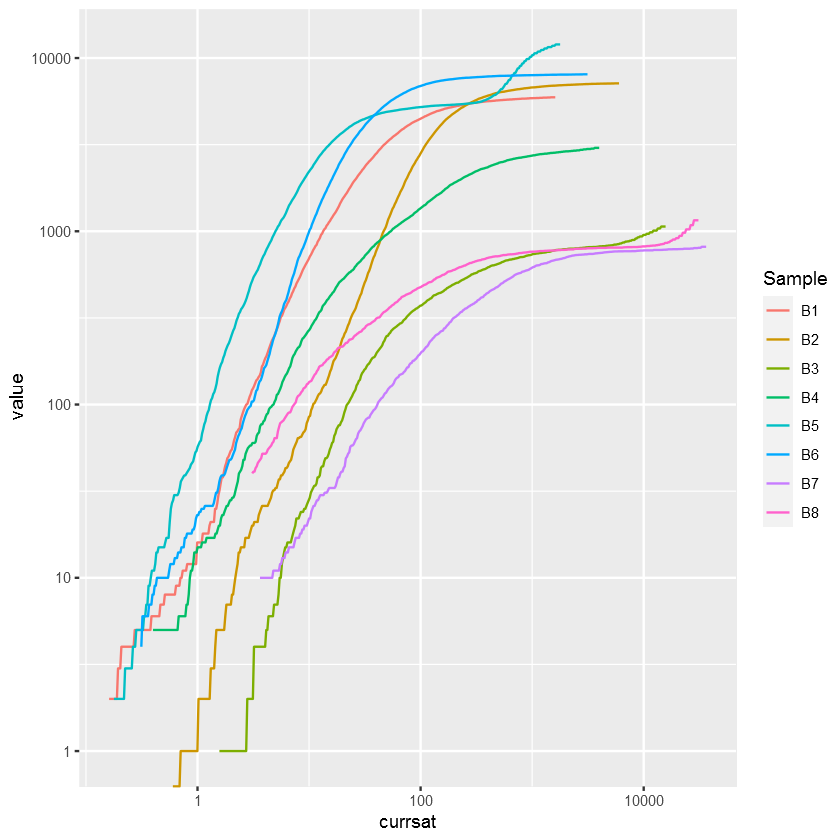

In [155]:
ggplot(df, aes(x =currsat , y =value)) + geom_line(aes(group = Sample, color = Sample)) + scale_x_log10() + scale_y_log10()

In [156]:
fracs = 10^seq(from = -4, to = 0, by =.01)

mat = matrix(0, 8, length(fracs))
i = 1
for (each in fracs) {
    lc$pseudocount = lc$R2CONSCOUNT*each
    a =lc %>% group_by(Sample) %>% summarize(frac = sum(pseudocount > 10))
    mat[,i] = a$frac
    i = i+1
} 
rownames(mat) = paste0('B', 1:8)

Warning message:
"Transformation introduced infinite values in continuous y-axis"


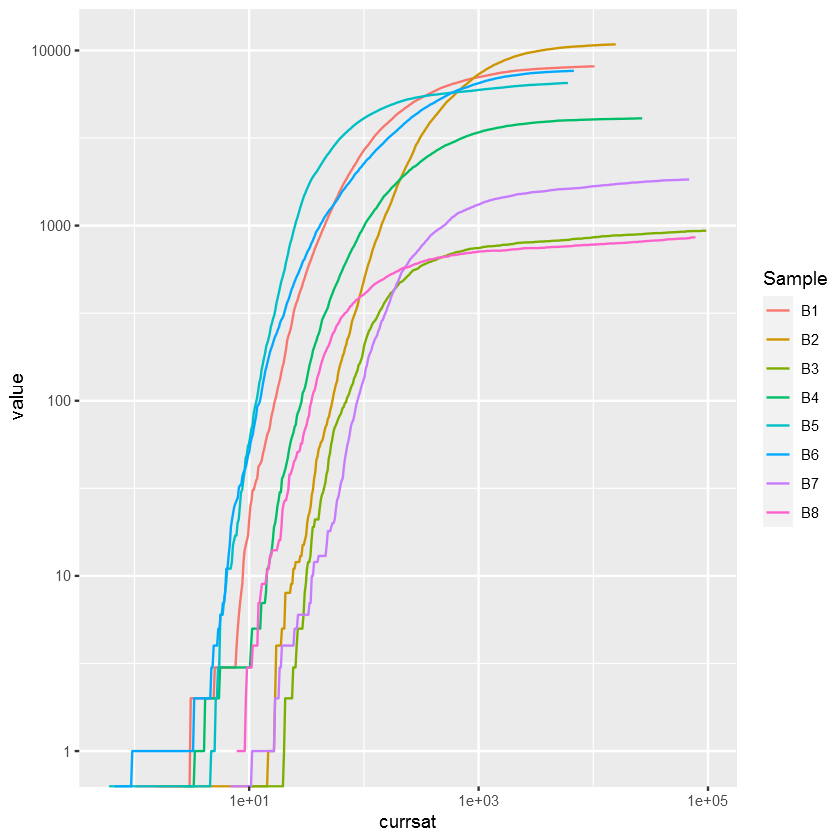

In [157]:
library(reshape2)
library(ggplot2)
colnames(mat) = fracs
mat = as.data.frame(mat)
mat$Sample =rownames(mat)
dfl = melt(mat, id.vars = 'Sample')
dfl$value = as.numeric(as.character(dfl$value))
a = dfl
dfl = as.data.frame(dfl)
#dfl = dfl %>% group_by(Sample) %>% mutate(value = value/max(value, na.rm = TRUE))
dfl$variable = as.numeric(as.character(dfl$variable))
dfl$maxsat = depth$satL[match(dfl$Sample, rownames(depth))]
dfl$currsat = dfl$maxsat*dfl$variable

ggplot(dfl, aes(x =currsat , y =value)) + geom_line(aes(group = Sample, color = Sample)) + scale_x_log10() + scale_y_log10()


In [158]:
head(dfl)

,Sample,variable,value,maxsat,currsat
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,B1,1e-04,0,10244.122,1.0244122
2,B2,1e-04,0,15705.529,1.5705529
3,B3,1e-04,0,96387.584,9.6387584
4,B4,1e-04,0,26691.091,2.6691091
5,B5,1e-04,0,6009.283,0.6009283
6,B6,1e-04,0,6772.831,0.6772831


In [159]:
df$Chain = 'Heavy'
dfl$Chain = 'Light'
df = rbind(df, dfl)

In [160]:
saveRDS(df, 'sat_metrics.RDS')